In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.face_trigger import FaceTrigger
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import re
import os
import cv2
import time
import pydot
import pickle
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [ ]:
g = g + 1

In [3]:
road_signs_path = '../data/rtsd/detection'
gt_re = re.compile('^rtsd.*-gt$')
sign_re = re.compile('^(mandatory)|(prohibitory)|(danger)|(blue_rect)]')
im_path_re = re.compile('-gt')
mode_re = re.compile('_gt.csv')

dataset = {}
target = {}

def read_dataset(path, dataset, target):
    im_path = os.path.basename(os.path.dirname(os.path.dirname(path)))
    im_path = im_path_re.sub('', im_path) + '-frames'
    mode = mode_re.sub('', os.path.basename(path))
    
    with open(path) as f:
        header = f.readline()

        for line in f:
            params = line.strip().split(',')
            
            if params[0] not in dataset:
                dataset[params[0]] = plt.imread(os.path.join(road_signs_path, im_path, mode, params[0]))
                target[params[0]] = np.zeros(dataset[params[0]].shape[:2])
                
            target[params[0]][int(params[1]) : int(params[1]) + int(params[3]),
                              int(params[2]) : int(params[2]) + int(params[4])] = 1


for folder_name in os.listdir(road_signs_path):
    if gt_re.match(folder_name):
        for t in os.listdir(os.path.join(road_signs_path, folder_name)):
            if sign_re.match(t):
                read_dataset(os.path.join(road_signs_path, folder_name, t, 'test_gt.csv'), dataset, target)
                read_dataset(os.path.join(road_signs_path, folder_name, t, 'train_gt.csv'), dataset, target)
        break

In [16]:
del target

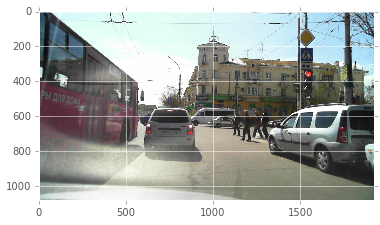

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


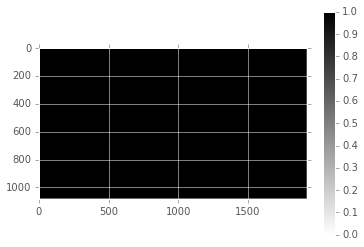

autosave16_04_2013_11_46_11_3.jpg autosave16_04_2013_11_46_11_3.jpg


In [12]:
i = 10
plt.imshow(dataset.values()[i])
plt.show()
plt.imshow(target.values()[i], interpolation='none', cmap=plt.cm.gray_r)
plt.colorbar()
plt.show()

print target.keys()[i], dataset.keys()[i]

In [16]:
target.values()[i].shape

(1080, 1920, 3)

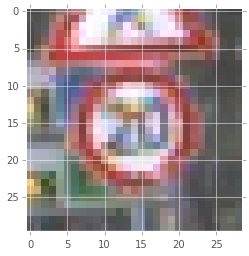

In [7]:
im = plt.imread(os.path.join(road_signs_path, 'GTSRB', 'Final_Training', 'Images', '00000', '00000_00000.ppm'))

# cv2.rectangle(im, (915, 426), (840, 349), (255, 255, 255), -1)
plt.imshow(im, interpolation='none')

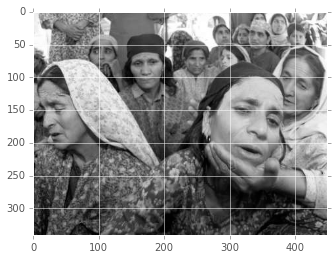

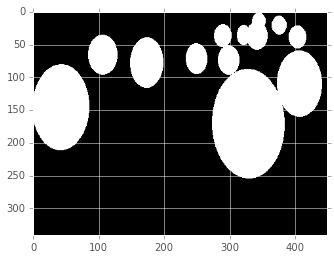

In [5]:
plt.imshow(dataset['FDDB-fold-03.txt'][0], cmap=plt.cm.gray)
plt.show()

plt.imshow(target['FDDB-fold-03-ellipseList.txt'][0], cmap=plt.cm.gray)
plt.show()

# Compile dataset

In [6]:
s = set()

for k, v in dataset.items():
    for im in v:
        s.add(im.shape)
        
shapes = np.array(list(s))
shape = shapes.max(axis=0)

In [7]:
def add_negative(im, pos_shape, negative):
    h1 = im.shape[0] - pos_shape[0]
    w1 = pos_shape[1]
    
    h2 = h1
    w2 = im.shape[1] - pos_shape[1]
    
    h3 = pos_shape[0]
    w3 = im.shape[1] - pos_shape[1]
    
    if h1 > 0 and w1 > 0:
        n = negative[np.random.choice(np.arange(len(negative)))]

        im[pos_shape[0]:pos_shape[0] + min([n.shape[0], h1]),
                       :               min([n.shape[1], w1])] = n[:min([n.shape[0], h1]),
                                                                  :min([n.shape[1], w1])]
        add_negative(im[pos_shape[0]:, :],
                     (min([n.shape[0], h1]), min([n.shape[1], w1])),
                     negative)
                     
    if h2 > 0 and w2 > 0:
        n = negative[np.random.choice(np.arange(len(negative)))]

        im[pos_shape[0]:pos_shape[0] + min([n.shape[0], h2]),
           pos_shape[1]:pos_shape[1] + min([n.shape[1], w2])] = n[:min([n.shape[0], h2]),
                                                                  :min([n.shape[1], w2])]
        add_negative(im[pos_shape[0]:pos_shape[0] + h2, pos_shape[1]:pos_shape[1] + w2],
                     (min([n.shape[0], h2]), min([n.shape[1], w2])),
                     negative)
                     
    if h3 > 0 and w3 > 0:
        n = negative[np.random.choice(np.arange(len(negative)))]

        im[            :min([n.shape[0], h3]),
           pos_shape[1]:pos_shape[1] + min([n.shape[1], w3])] = n[:min([n.shape[0], h3]),
                                                                  :min([n.shape[1], w3])]
        add_negative(im[:h3, pos_shape[1]:pos_shape[1] + w3],
                     (min([n.shape[0], h3]), min([n.shape[1], w3])),
                     negative)


def build_mosaic(shape, im, negative=None):
    moisaic = np.zeros(shape)
    moisaic[:im.shape[0], :im.shape[1]] = im
    
    if negative is not None:
        add_negative(moisaic, im.shape, negative)

    return moisaic

In [9]:
negative_path = '../data/256_ObjectCategories/'
negative = []

for d in os.listdir(negative_path):
    for im_name in os.listdir(os.path.join(negative_path, d)):
        im = cv2.imread(os.path.join(negative_path, d, im_name), 0)
        
        if im is not None:
            negative.append(im)
        
np.random.shuffle(negative)

In [10]:
mosaic_dataset = {}
mosaic_target = {}

for k, v in dataset.items():
    mosaic_dataset[k] = [None] * len(v)
    
    for i, im in enumerate(v):
        mosaic_dataset[k][i] = build_mosaic(shape, im, negative).astype(np.uint8)
        
for k, v in target.items():
    mosaic_target[k] = [None] * len(v)
    
    for i, im in enumerate(v):
        mosaic_target[k][i] = build_mosaic(shape, im).astype(np.uint8)

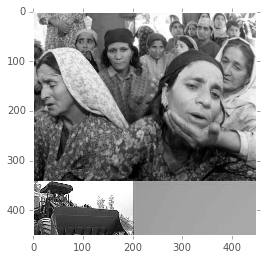

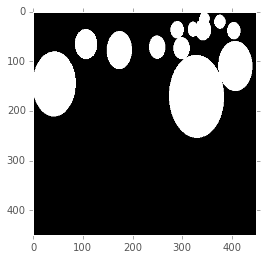

In [12]:
plt.imshow(mosaic_dataset.items()[0][1][0], cmap=plt.cm.gray)
plt.grid(False)
plt.show()

plt.imshow(mosaic_target.items()[0][1][0], cmap=plt.cm.gray)
plt.grid(False)
plt.show()

In [13]:
with open('../data/faces.npz', 'wb') as f:
    pickle.dump([mosaic_dataset, mosaic_target], f)

In [4]:
with open('../data/faces.npz') as f:
    mosaic_dataset, mosaic_target = pickle.load(f)

In [5]:
X = np.array(list(itertools.chain(*mosaic_dataset.values())))
y = np.array(list(itertools.chain(*mosaic_target.values())))

In [6]:
X_y = train_test_split(X.reshape(-1, 1, 450, 450).astype(np.float32),
                       y.reshape(-1, 1, 450, 450).astype(np.float32))

# Simple network

In [12]:
network = FaceTrigger(img_shape=(450, 450),
                      learning_rate=1e-3,
                      c=1.0,
                      c_complexity=0,
                      c_sub_objs=[0, 0, 0, 0],
                      c_sub_obj_cs=[0, 0, 0, 0],
                      mul=False,
                      pool_sizes=[2, 2, 2, 4],
                      num_filters=[1, 16, 32, 64],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

<IPython.core.display.Javascript object>


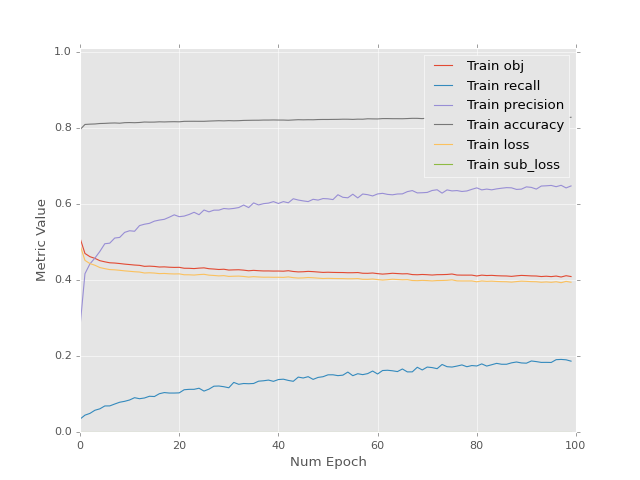

<IPython.core.display.Javascript object>


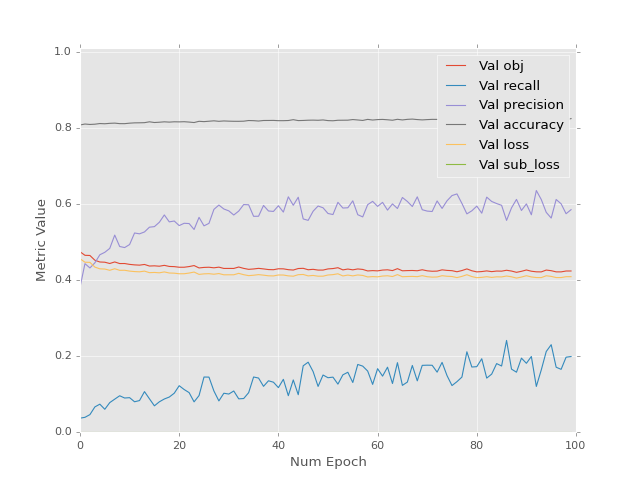

<IPython.core.display.Javascript object>


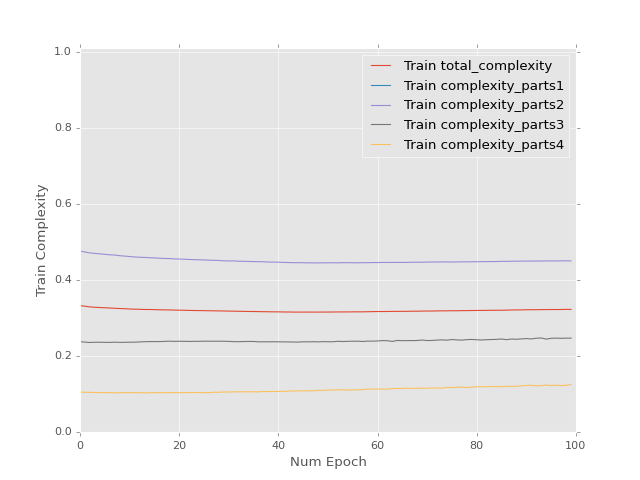

<IPython.core.display.Javascript object>


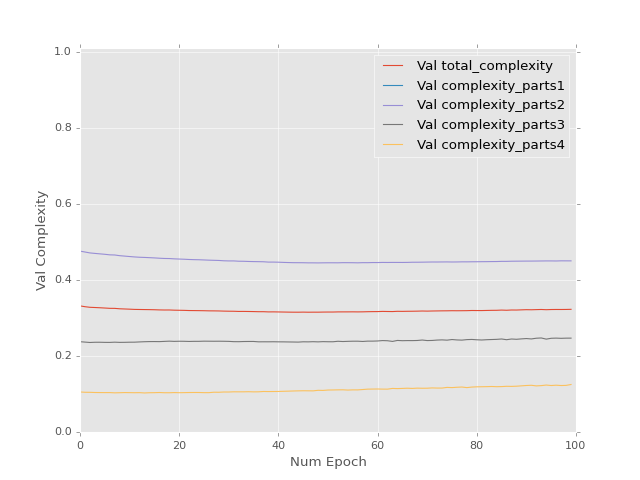

Epoch 1 of 100 took 149.025s
Epoch 2 of 100 took 149.791s
Epoch 3 of 100 took 149.302s
Epoch 4 of 100 took 149.551s
Epoch 5 of 100 took 149.898s
Epoch 6 of 100 took 149.570s
Epoch 7 of 100 took 149.262s
Epoch 8 of 100 took 149.491s
Epoch 9 of 100 took 149.623s
Epoch 10 of 100 took 149.370s
Epoch 11 of 100 took 149.440s
Epoch 12 of 100 took 149.197s
Epoch 13 of 100 took 149.165s
Epoch 14 of 100 took 149.814s
Epoch 15 of 100 took 149.411s
Epoch 16 of 100 took 149.692s
Epoch 17 of 100 took 149.286s
Epoch 18 of 100 took 149.323s
Epoch 19 of 100 took 149.225s
Epoch 20 of 100 took 149.275s
Epoch 21 of 100 took 149.286s
Epoch 22 of 100 took 149.120s
Epoch 23 of 100 took 149.821s
Epoch 24 of 100 took 149.147s
Epoch 25 of 100 took 149.499s
Epoch 26 of 100 took 149.426s
Epoch 27 of 100 took 149.274s
Epoch 28 of 100 took 149.334s
Epoch 29 of 100 took 149.722s
Epoch 30 of 100 took 149.433s
Epoch 31 of 100 took 149.406s
Epoch 32 of 100 took 149.195s
Epoch 33 of 100 took 149.254s
Epoch 34 of 100 too

In [13]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

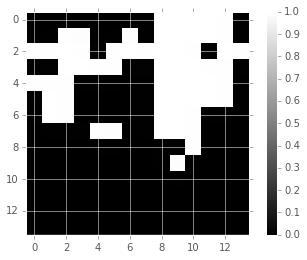

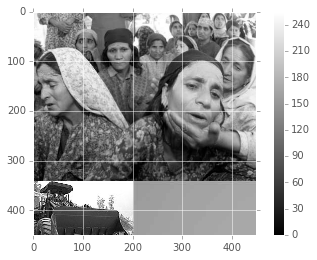

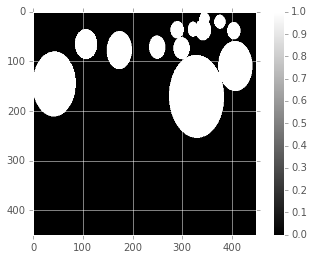

In [40]:
%matplotlib inline

plt.imshow(network.predict(X[0].reshape(1, 1, 450, 450))[0, 0] > 0.5, cmap=plt.cm.gray, interpolation='none')
plt.colorbar()
plt.show()
plt.imshow(X[0], cmap=plt.cm.gray)
plt.colorbar()
plt.show()
plt.imshow(y[0], cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [ ]:
network = FaceTrigger(img_shape=(450, 450),
                      learning_rate=5e-4,
                      c=1.0,
                      c_complexity=0,
                      c_sub_objs=[0, 0, 0, 0],
                      c_sub_obj_cs=[1, 1, 1, 1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 4],
                      num_filters=[1, 32, 64, 128],
                      filter_sizes=[1, 3, 3, 3],
                      l2_c=1e-4)

In [34]:
network.load('../weights/', 'faces')

<IPython.core.display.Javascript object>


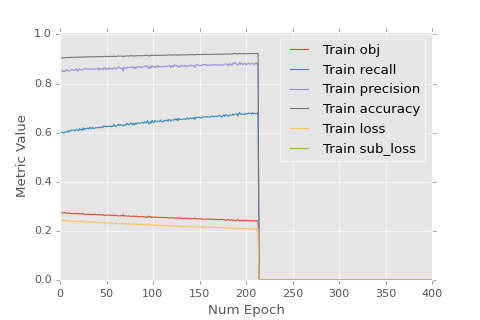

<IPython.core.display.Javascript object>


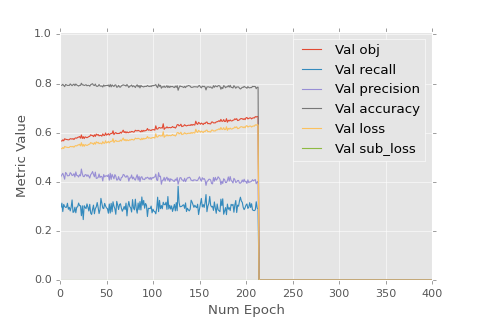

<IPython.core.display.Javascript object>


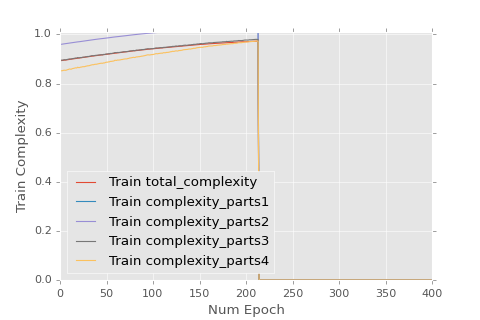

<IPython.core.display.Javascript object>


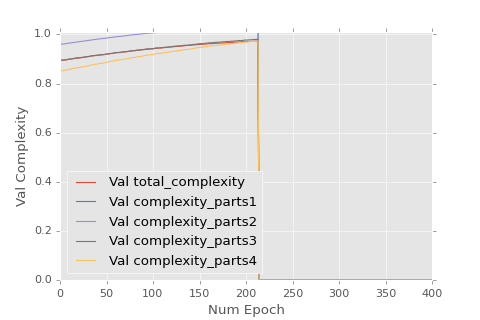

Epoch 1 of 400 took 234.217s
Epoch 2 of 400 took 236.031s
Epoch 3 of 400 took 235.014s
Epoch 4 of 400 took 235.630s
Epoch 5 of 400 took 235.626s
Epoch 6 of 400 took 236.368s
Epoch 7 of 400 took 235.165s
Epoch 8 of 400 took 235.658s
Epoch 9 of 400 took 235.502s
Epoch 10 of 400 took 235.414s
Epoch 11 of 400 took 235.110s
Epoch 12 of 400 took 235.445s
Epoch 13 of 400 took 235.352s
Epoch 14 of 400 took 235.685s
Epoch 15 of 400 took 235.479s
Epoch 16 of 400 took 235.732s
Epoch 17 of 400 took 235.381s
Epoch 18 of 400 took 235.441s
Epoch 19 of 400 took 235.581s
Epoch 20 of 400 took 235.319s
Epoch 21 of 400 took 235.510s
Epoch 22 of 400 took 235.642s
Epoch 23 of 400 took 235.535s
Epoch 24 of 400 took 235.233s
Epoch 25 of 400 took 235.168s
Epoch 26 of 400 took 235.056s
Epoch 27 of 400 took 235.786s
Epoch 28 of 400 took 235.737s
Epoch 29 of 400 took 235.655s
Epoch 30 of 400 took 235.710s
Epoch 31 of 400 took 235.630s
Epoch 32 of 400 took 235.430s
Epoch 33 of 400 took 235.720s
Epoch 34 of 400 too

In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=400,
      batch_size=25)

In [37]:
network.save('../weights/', 'faces400')

In [28]:
print 1

1
